# Importing packages

In [ ]:
!pip install tensorflow

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
import os
import xlrd
import random
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display

## Using zipfile to extract its contents.

In [3]:
import zipfile

## Import Tensorflow as tf and from tf.keras

In [4]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
tf.__version__

'2.1.0'

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Load Data

local_zip = 'RA detection/Training Data/RH/RH-Cropped.zip' # local path of downloaded .zip file
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/RA detection/Training Data/RH-Cropped') # contents are extracted to '/tmp' folder
zip_ref.close()

In [153]:
base_dir = 'C:/Users/liqui/OneDrive/Grad Studies/Winter 2020/M228/Final Project Data/training/Organized images'
train_dir = os.path.join(base_dir, 'trainJPEG')
validation_dir = os.path.join(base_dir, 'validationJPEG')
trainIMG_count = len(os.listdir(train_dir))
validIMG_count = len(os.listdir(validation_dir))
BATCH_SIZE = 8
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(trainIMG_count/BATCH_SIZE)
print('number of images in training set = ',trainIMG_count)
print('number of images in validation set = ',validIMG_count)

number of images in training set =  2635
number of images in validation set =  500


Need to take the name of each image and navigate the excel sheet to get it's score.
The rows of the excel sheet corresponds to the patient id and the columns correspond to the each joint.

import pathlib
base_dir=pathlib.Path(base_dir)
print(base_dir)
for item in base_dir.iterdir():
  print(item)

import random
all_image_paths = list(base_dir.glob('**/*.tif'))
#“**” pattern means “this directory and all subdirectories, recursively”
#given relative pattern in the directory represented by this path, yielding all matching files
random.shuffle(all_image_paths)
for path in all_image_paths:
    print(pathlib.PurePosixPath(path).name)
all_image_paths = [str(path) for path in all_image_paths]
#random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count
#all_image_paths

In [12]:
train_dir=pathlib.Path(train_dir)
print(train_dir)
validation_dir=pathlib.Path(validation_dir)
print(validation_dir)
#for item in train_dir.iterdir():
 # print(item)

C:\Users\liqui\OneDrive\Grad Studies\Winter 2020\M228\Final Project Data\training\Organized images\trainJPEG
C:\Users\liqui\OneDrive\Grad Studies\Winter 2020\M228\Final Project Data\training\Organized images\validationJPEG


In [53]:
all_image_paths = list(train_dir.glob('**/*.jpg'))
val_image_paths = list(validation_dir.glob('**/*.jpg'))
#“**” pattern means “this directory and all subdirectories, recursively”
#given relative pattern in the directory represented by this path, yielding all matching files
#print(random.shuffle(all_image_paths))
#list_ds = tf.data.Dataset.list_files(train_dir)

# Processing the image titles

## Exploring the the Excell file containing the joint scores 

In [37]:
#Get labels
jointNum = []#column labels
patientsID=[]#row labels
scores = xlrd.open_workbook('scores.xlsx')
sheet = scores.sheet_by_index(0)
for i in range(1,sheet.ncols):
    jointNum.append(sheet.cell_value(0,i))
for i in range(1,sheet.nrows):#sheet.nrows
    patientsID.append(sheet.cell_value(i,0))
colSymb=[]
for col in range(1,sheet.ncols):
    colSymb.append(xlrd.formula.colname(col)) 
JointDict = dict(zip(jointNum,range(1,sheet.ncols)))
PatientsDict = dict(zip(patientsID,range(1,sheet.nrows)))
print(PatientsDict)
print(jointNum)

{'UAB001': 1, 'UAB002': 2, 'UAB003': 3, 'UAB005': 4, 'UAB006': 5, 'UAB007': 6, 'UAB008': 7, 'UAB009': 8, 'UAB012': 9, 'UAB013': 10, 'UAB018': 11, 'UAB021': 12, 'UAB022': 13, 'UAB023': 14, 'UAB024': 15, 'UAB028': 16, 'UAB030': 17, 'UAB031': 18, 'UAB032': 19, 'UAB033': 20, 'UAB035': 21, 'UAB036': 22, 'UAB037': 23, 'UAB039': 24, 'UAB040': 25, 'UAB041': 26, 'UAB042': 27, 'UAB045': 28, 'UAB046': 29, 'UAB049': 30, 'UAB050': 31, 'UAB051': 32, 'UAB052': 33, 'UAB054': 34, 'UAB055': 35, 'UAB056': 36, 'UAB057': 37, 'UAB058': 38, 'UAB059': 39, 'UAB060': 40, 'UAB061': 41, 'UAB062': 42, 'UAB063': 43, 'UAB064': 44, 'UAB065': 45, 'UAB066': 46, 'UAB067': 47, 'UAB068': 48, 'UAB069': 49, 'UAB070': 50, 'UAB071': 51, 'UAB075': 52, 'UAB078': 53, 'UAB079': 54, 'UAB080': 55, 'UAB081': 56, 'UAB084': 57, 'UAB085': 58, 'UAB086': 59, 'UAB087': 60, 'UAB088': 61, 'UAB090': 62, 'UAB093': 63, 'UAB096': 64, 'UAB098': 65, 'UAB099': 66, 'UAB100': 67, 'UAB101': 68, 'UAB102': 69, 'UAB103': 70, 'UAB104': 71, 'UAB105': 72, 

In [46]:
CLASS_NAME =  ['0', '1', '2', '3', '4', '5']
SCORE_VAL =  np.array(range(6), dtype='<U10')
print(CLASS_NAME)
print(SCORE_VAL)
for i in CLASS_NAME:
    if not os.path.exists(os.path.join(base_dir,'ClassifiedTr', i)):
       os.mkdir(os.path.join(base_dir,os.path.join('ClassifiedTr', i)))
    else:
        print('Training class ', i, ' directory exists')
for i in CLASS_NAME:
    if not os.path.exists(os.path.join(base_dir,'ClassifiedVal', i)):
       os.mkdir(os.path.join(base_dir,os.path.join('ClassifiedVal', i)))
    else:
        print('Validation class ', i, ' directory exists')

['0', '1', '2', '3', '4', '5']
['0' '1' '2' '3' '4' '5']
Validation class  0  directory exists
Validation class  1  directory exists
Validation class  2  directory exists
Validation class  3  directory exists
Validation class  4  directory exists
Validation class  5  directory exists


## Define a function to get take the image file name and then get the scores from the Excel file

In [55]:
def get_score(image_path):
    word = pathlib.PurePosixPath(image_path).name
    #print(word)
    buff1 = word.rsplit("_")
    #print(buff1)
    if len(buff1)==2:
        PID = str(buff1[0])
        buff2 = buff1[1].rsplit(".")
        #print(buff2)
        if len(buff2)==2:
            JNum = str(buff2[0])
    #print("%5s"%PID,sep=' ', end='', flush=True)
    #print(JNum),
    return str(int(sheet.cell_value(PatientsDict.get(PID),JointDict.get(JNum))))#==CLASS_NAME

## Distribute the TRAINING images based on their score into class folders

In [48]:
from shutil import copy2
for p in range(len(all_image_paths)-1):
    #print(p)
    #print(all_image_paths[p])
    A =  get_score(all_image_paths[p])
    findClass = CLASS_NAME.index(str(A))
    #print(findClass)
    copy2(all_image_paths[p],os.path.join(os.path.join('ClassifiedTr', str(findClass))))
Trclass_dir = os.path.join(base_dir, 'ClassifiedTr')
Trclass_dir=pathlib.Path(Trclass_dir)

## Distribute the VALIDATION images based on their score into class folders

In [56]:
from shutil import copy2
for p in range(len(val_image_paths)-1):
    #print(p)
    #print(all_image_paths[p])
    A =  get_score(val_image_paths[p])
    findClass = CLASS_NAME.index(str(A))
    #print(findClass)
    copy2(all_image_paths[p],os.path.join(os.path.join('ClassifiedVal', str(findClass))))
Valclass_dir = os.path.join(base_dir, 'ClassifiedVal')
Valclass_dir=pathlib.Path(Valclass_dir)

## visualizing Trainig Data

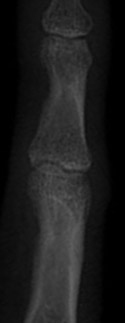

0


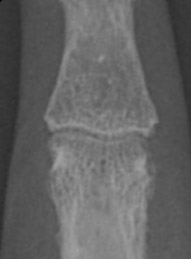

0


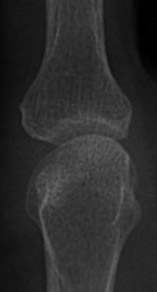

0


In [57]:
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path))
    print(get_score(image_path))


## Visualizing Validation Data

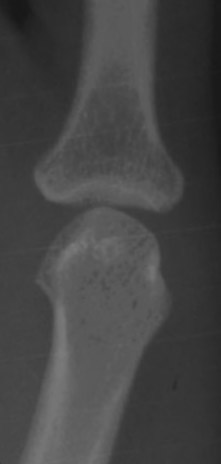

0


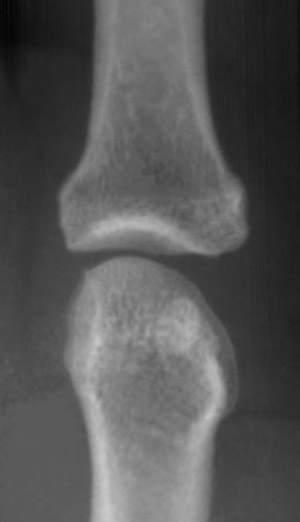

0


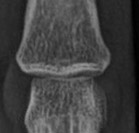

0


In [60]:
for n in range(3):
    image_path = random.choice(val_image_paths)
    display.display(display.Image(image_path))
    print(get_score(image_path))


## 1- Generating labels for each image --> use the get_score function
## 2- Decoding images


In [154]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [155]:
train_data_gen = image_generator.flow_from_directory(directory=Trclass_dir,
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(SCORE_VAL))

Found 2633 images belonging to 6 classes.


In [156]:
validation_data_gen = image_generator.flow_from_directory(directory=Valclass_dir,
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(SCORE_VAL))

Found 499 images belonging to 6 classes.


In [161]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(6):
        ax = plt.subplot(3,3,n+1)
        plt.imshow(image_batch[n])
        plt.title(SCORE_VAL[label_batch[n]==1][0].title())
        plt.axis('off')


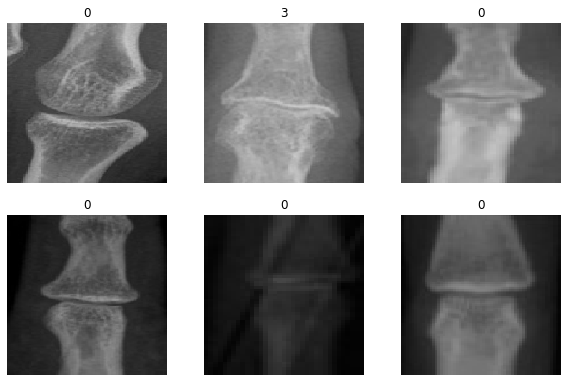

In [162]:

image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)


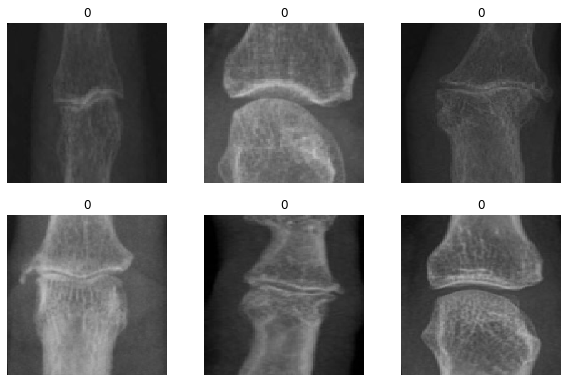

In [173]:

image_batch, label_batch = next(validation_data_gen)
show_batch(image_batch, label_batch)


In [174]:
Tr_list_ds = tf.data.Dataset.list_files(str(Trclass_dir/'*/*'))
Val_list_ds = tf.data.Dataset.list_files(str(Valclass_dir/'*/*'))

In [175]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAME

In [176]:
def decode_img(img):
    #convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    img = tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])
    #img /= 255.0  # normalize to [0,1] range
    return img


In [177]:
def process_path(image_path):
    label = get_label(image_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(image_path)
    img = decode_img(img)
    return img, label

In [178]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
Tr_labeled_ds = Tr_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
Val_labeled_ds =Val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

## Look at one lable for varification

In [179]:
for image, label in Tr_labeled_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())


Image shape:  (224, 224, 3)
Label:  [False False  True False False False]


In [180]:
for image, label in Val_labeled_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())


Image shape:  (224, 224, 3)
Label:  [ True False False False False False]


# Train

In [181]:
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return decode_img(image)

In [182]:
Trclass_image_paths = list(Trclass_dir.glob('*/*'))
Trclass_image_paths = [str(path) for path in Trclass_image_paths]
random.shuffle(Trclass_image_paths)

image_count = len(Trclass_image_paths)
image_count

2633

In [183]:
Valclass_image_paths = list(Valclass_dir.glob('*/*'))
Valclass_image_paths = [str(path) for path in Valclass_image_paths]
random.shuffle(Valclass_image_paths)

image_count = len(Valclass_image_paths)
image_count

499

In [184]:
Tr_path_ds = tf.data.Dataset.from_tensor_slices(Trclass_image_paths)

In [185]:
Val_path_ds = tf.data.Dataset.from_tensor_slices(Valclass_image_paths)

In [186]:
Tr_image_ds = Tr_path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

In [187]:
Val_image_ds = Val_path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

ValueError: num must be 1 <= num <= 4, not 5

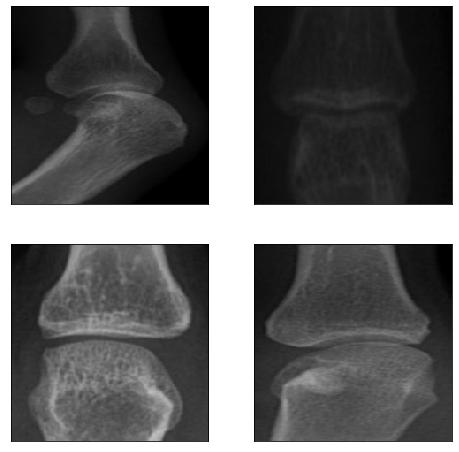

In [188]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
for n,image in enumerate(Tr_image_ds.shuffle(1)):
        image_path = random.choice(Trclass_image_paths)
        plt.subplot(2,2,n+1)
        plt.imshow(image)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
    #lt.xlabel(get_score(class_image_paths[n]))

# Model Creation

The model consists of 3 convolution blocks with max pool layer in each of them. We have a fully connected layer with 512 units on top of it, which is activated by **relu** activation function. Model will output class probabilities based on binary classification which is done by **sigmoid** activation function. 

In [189]:
model = Sequential()
model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_WIDTH,IMG_HEIGHT, 3,))) 
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

### Compiling the model

We will use **ADAM** optimizer as our choice of optimizer for this task and **binary cross entropy** function as a loss function. We would also like to look at training and validation accuracy on each epoch as we train our network, for that we are passing it in the metrics argument.

In [190]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy']
             )

### Compiling the model

We will use **ADAM** optimizer as our choice of optimizer for this task and **binary cross entropy** function as a loss function. We would also like to look at training and validation accuracy on each epoch as we train our network, for that we are passing it in the metrics argument.

### Model Summary

Let's look at all the layers of our network using **summary** method.

In [191]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 50176)            

### Train the model

Its time we train our network. We will use **fit_generator** function to train our network instead of **fit** function, as we are using **ImageDataGenerator** class to generate batches of training and validation data for our network. 

In [192]:
history = model.fit_generator(
    train_data_gen,
    STEPS_PER_EPOCH,
    epochs=BATCH_SIZE,
    validation_data=validation_data_gen,
    validation_steps=int(np.ceil(499 / float(BATCH_SIZE)))
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 330.0 steps, validate for 63 steps
Epoch 1/8
330/330 [==============================] - 116s 351ms/step - loss: 0.4654 - accuracy: 0.8331 - val_loss: 0.4507 - val_accuracy: 0.8333
Epoch 2/8
330/330 [==============================] - 111s 338ms/step - loss: 0.4507 - accuracy: 0.8333 - val_loss: 0.4506 - val_accuracy: 0.8333
Epoch 3/8
330/330 [==============================] - 116s 350ms/step - loss: 0.4506 - accuracy: 0.8333 - val_loss: 0.4506 - val_accuracy: 0.8333
Epoch 4/8
330/330 [==============================] - 115s 350ms/step - loss: 0.4506 - accuracy: 0.8333 - val_loss: 0.4506 - val_accuracy: 0.8333
Epoch 5/8
330/330 [==============================] - 114s 346ms/step - loss: 0.4506 - accuracy: 0.8333 - val_loss: 0.4506 - val_accuracy: 0.8333
Epoch 6/8
330/330 [==============================] - 115s 347ms/step - loss: 0.4506 - accuracy: 0.8333 - val_loss: 0.4506 - val_accuracy: 0.8333
Epoch 7/8
330/330 [================

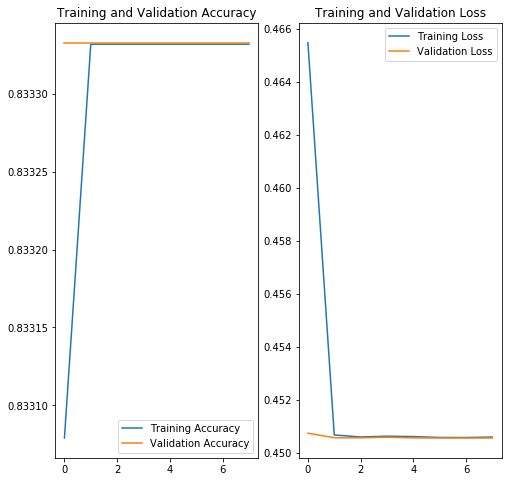

In [193]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(BATCH_SIZE)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [194]:
# Clear resources
tf.keras.backend.clear_session()
epochs = 20

In [195]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

In [196]:
train_data_gen = image_gen.flow_from_directory(
                                                batch_size=BATCH_SIZE, 
                                                directory=Trclass_dir, 
                                                shuffle=True, 
                                                target_size=(IMG_HEIGHT, IMG_WIDTH)
                                                )

Found 2633 images belonging to 7 classes.


Let's take 1 sample image from our training examples and repeat it 5 times so that the augmentation can be applied to the same image 5 times over randomly, to see the augmentation in action.

In [197]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

In [198]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

In [199]:
train_data_gen = image_gen.flow_from_directory(
                                                batch_size=BATCH_SIZE, 
                                                directory=Trclass_dir, 
                                                shuffle=True, 
                                                target_size=(IMG_HEIGHT, IMG_WIDTH)
                                                )

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 2633 images belonging to 7 classes.


### Applying Zoom

Let's apply Zoom augmentation to our dataset to zoom images up to 50% randomly.

In [200]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)

In [201]:
train_data_gen = image_gen.flow_from_directory(
                                                batch_size=BATCH_SIZE, 
                                                directory=Trclass_dir, 
                                                shuffle=True, 
                                                target_size=(IMG_HEIGHT, IMG_WIDTH)
                                                )

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 2633 images belonging to 7 classes.


### Putting it all together

We can apply all the augmentations we saw above and even more with just one line of code. We can simply pass the augmentations as arguments with proper values and that would be all.

Here, we have applied rescale, rotation of 45 degrees, width shift, height shift, horizontal flip and zoom augmentation to our training images.

In [202]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255, 
                    rotation_range=45, 
                    width_shift_range=.15, 
                    height_shift_range=.15, 
                    horizontal_flip=True, 
                    zoom_range=0.5
                    )

In [203]:
train_data_gen = image_gen_train.flow_from_directory(
                                                batch_size=BATCH_SIZE, 
                                                directory=Trclass_dir, 
                                                shuffle=True, 
                                                target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                class_mode='binary'
                                                )

Found 2633 images belonging to 7 classes.


Let's visualize how a single image would look like 5 different times, when we pass these augmentations randomly to our dataset. 

In [204]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]


### Creating Validation Data generator

Generally, we only apply data augmentation to our training examples. So, in this case we are only rescaling our validation images and converting them into batches using ImageDataGenerator.

In [205]:
image_gen_val = ImageDataGenerator(rescale=1./255)

In [206]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE, 
                                                 directory=Valclass_dir, 
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 499 images belonging to 6 classes.


# Dropout 

Another technique we can use to reduce overfitting is to introduce something called **Dropout** to our network. If you are not familiar with the term **regularization**, it simply means forcing the weights in your network to take only small values, which makes the distribution of weight values more regular and the network can reduce overfitting on small training examples. Dropout is one of the regularization technique we will be using in this tutorial.

When we apply Dropout to a layer it will randomly drop out (set to zero) number of output units from the applied layer during the training process. Dropout takes fraction number as its input value, in the form such as 0.1, 0.2, 0.4 etc. which simply means dropping out 10%, 20% or 40% of the output units randomly from the applied layer. 

When we apply 0.1 value as a Dropout value to a certain layer, it will kill 10% of its output units randomly in each training epoch.

Let's create a network architecture with this new Dropout feature and apply it to different Convolutions and Fully Connected layers.

# Creating a new network with Dropouts

Here, we have applied Dropouts to first and last max pool layers and to a fully connected layer which has 512 output units. 30% of the first and last max pool layer and 10% of fully connected layer output units will be set to zero randomly during each epoch while training. 

In [207]:
model = Sequential()
model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_WIDTH,IMG_HEIGHT, 3,))) 
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

### Compiling the model

After introducing Dropouts to our network, let us compile the model and see the layers summary.

In [208]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy']
             )

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0

### Training the model

After successfully introducing Data Augmentations to our training examples and adding Dropouts to our network, let us now train this new network.

In [209]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(trainIMG_count / float(BATCH_SIZE))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(validIMG_count / float(BATCH_SIZE)))
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 330 steps, validate for 63 steps
Epoch 1/20
330/330 [==============================] - 125s 378ms/step - loss: -10105680986.1635 - accuracy: 0.8572 - val_loss: 162816637448.1270 - val_accuracy: 0.0000e+00
Epoch 2/20
330/330 [==============================] - 123s 373ms/step - loss: -912468009664.0846 - accuracy: 0.8580 - val_loss: 6987402089033.1426 - val_accuracy: 0.0000e+00
Epoch 3/20
330/330 [==============================] - 128s 387ms/step - loss: -11836264453567.9316 - accuracy: 0.8580 - val_loss: 59774757852501.3359 - val_accuracy: 0.0000e+00
Epoch 4/20
330/330 [==============================] - 128s 389ms/step - loss: -57854016203863.7188 - accuracy: 0.8580 - val_loss: 233515129395557.5938 - val_accuracy: 0.0000e+00
Epoch 5/20
330/330 [==============================] - 132s 400ms/step - loss: -179749947535947.5625 - accuracy: 0.8580 - val_loss: 641976347830954.6250 - val_accuracy: 0.0000e+00
Epoch 6/20
330/330 [=======

### Visualizing the model

Let us visualize our new model after the training and see if we can find any sign of overfitting in it.

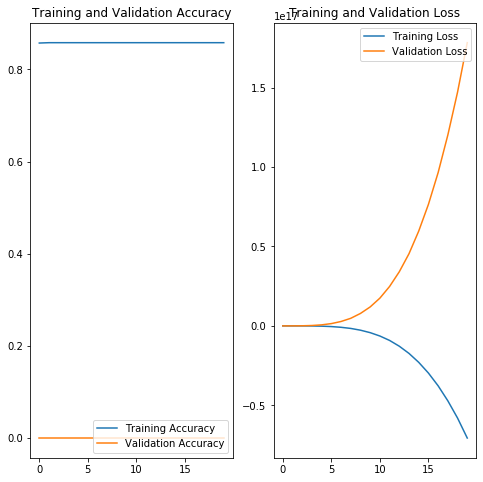

In [213]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()